In [2]:
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

In [12]:
guess = {
    "Historical price": (35000, 7500),
    "Snowblower price": (3000, 500),
    "Trip price": (12000, 3000), 
}

Text(0.01, 0.5, 'Density')

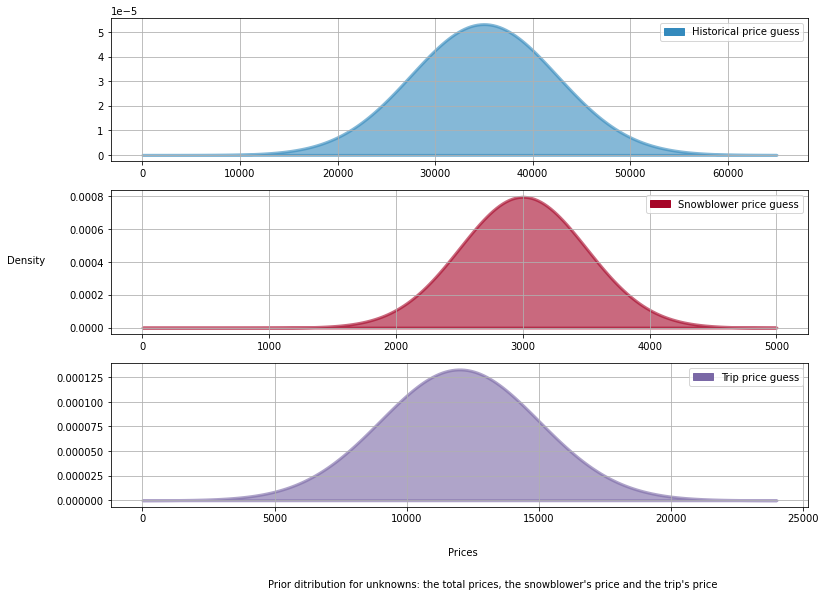

In [30]:
fig, axes = plt.subplots(figsize=(12.5, 9), nrows=3)

colors = ["#348ABD", "#A60628", "#7A68A6"]

for i, (label, (mu, std)) in enumerate(guess.items()):
    ax = axes[i]
    color = colors[i]
    label = f"{label} guess"
    x = np.linspace(0, mu + 4 * std, 200)
    ax.fill_between(x, 0, ss.norm.pdf(x, loc=mu, scale=std), color=color, 
                    lw=3, alpha=0.6, label=label)
    pl = plt.Rectangle((0, 0), 1, 1, color=color)
    ax.legend([pl], [label])
    ax.grid()
fig.text(0.3, 0, "Prior ditribution for unknowns: the total prices, the snowblower's price and the trip's price")
fig.text(0.5, 0.05, "Prices")
fig.text(0.01, 0.5, "Density")

In [118]:
true_price = pm.Normal("true_price", guess["Historical price"][0], 
                       1.0 / guess["Historical price"][1] ** 2)
prize_1 = pm.Normal("snowblower_price", guess["Snowblower price"][0], 
                    1.0 / guess["Snowblower price"][1] ** 2)
prize_2 = pm.Normal("trip_price", guess["Trip price"][0], 
                    1.0 / guess["Trip price"][1] ** 2)
price_estimate = prize_1 + prize_2

@pm.potential
def error(true_price=true_price, price_estimate=price_estimate):
    return pm.normal_like(true_price, price_estimate, 1 / 3e3 ** 2)

mcmc = pm.MCMC([true_price, prize_1, prize_2, price_estimate, error])
mcmc.sample(50000, 10000)

 [-----------------100%-----------------] 50000 of 50000 complete in 4.3 sec

Text(0.5, 1.0, 'Posterior of the true price estimate')

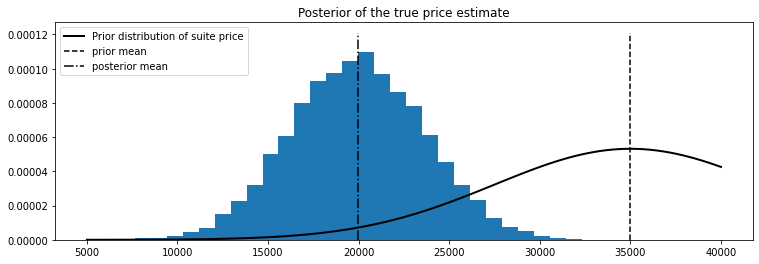

In [120]:
plt.figure(figsize=(12.5, 4))

# Plot the prior distribution
x = np.linspace(5000, 40000, 100)
y = ss.norm.pdf(x, loc=guess["Historical price"][0], scale=guess["Historical price"][1])
plt.plot(x, y, c="k", lw=2, label="Prior distribution of suite price")

# Plot the posterior distribution, represented by samples from mcmc
price_trace = mcmc.trace("true_price")[:]
_hist = plt.hist(price_trace, bins=35, density=True, histtype="stepfilled")
plt.vlines(guess["Historical price"][0], 0, _hist[0].max() * 1.1, 
           label="prior mean", linestyles="--")
plt.vlines(price_trace.mean(), 0, _hist[0].max() * 1.1, 
           label="posterior mean", linestyles="-.")
plt.legend(loc="upper left")
plt.title("Posterior of the true price estimate")

# maybe 20000 is better for this bidding

出价损失

In [150]:
def bid_loss(guess_price: float, true_prices: np.ndarray, risk=80000):
    result = np.zeros_like(true_prices)
    diff = true_prices - guess_price
    result[diff < 0] = risk
    result[np.bitwise_and(diff <= 250, diff > 0)] = -2 * true_prices[np.bitwise_and(diff <= 250, diff > 0)]
    result[diff > 250] = true_prices[diff > 250] - guess_price - 250
    return result.mean()

In [130]:
import scipy.optimize as sop

Minimum at risk 30000.0: [14604.76559401]
Minimum at risk 54000.0: [13439.67998028]
Minimum at risk 78000.0: [12311.8699193]
Minimum at risk 102000.0: [12305.16278744]
Minimum at risk 126000.0: [11932.1397543]
Minimum at risk 150000.0: [11775.97618103]


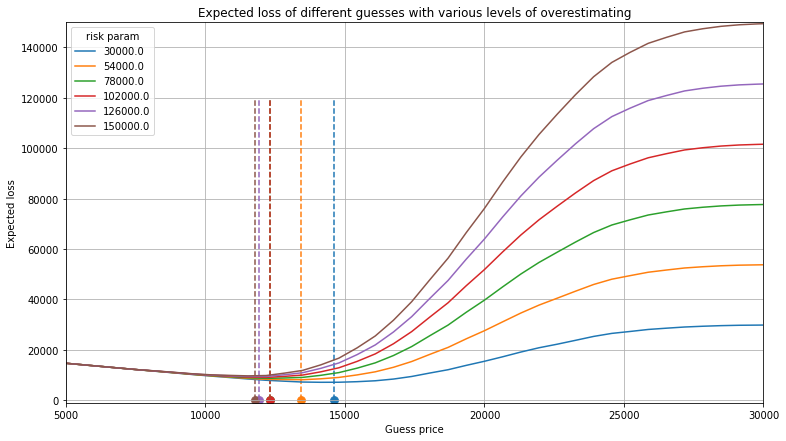

In [154]:
guesses = np.linspace(5000, 50000, 70)
risks = np.linspace(30000, 150000, 6)

plt.figure(figsize=(12.5, 7))
for risk in risks:
    min_v = sop.fmin(bid_loss, 15000, args=(price_trace, risk,), disp=False)
    losses = [bid_loss(guess, price_trace, risk).mean() for guess in guesses]
    p = plt.plot(guesses, losses, label=str(risk))
    color = p[0].get_color()
    plt.scatter(min_v, 0, s=60, color=color)
    plt.vlines(min_v, 0, 120000, color=color, linestyles="--")
    print(f"Minimum at risk {risk}: {min_v}")
    
plt.title("Expected loss of different guesses with various levels of overestimating")
plt.legend(loc="upper left", title="risk param")
plt.xlabel("Guess price")
plt.ylabel("Expected loss")
plt.xlim(5000, 30000)
plt.ylim(-1000, 150000)
plt.grid()